### Surprise Housing 

#### - By Nivedita Bhardwaj


<b>Problem statement </b> : Build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.


The company wants to know:
1. Which variables are significant in predicting the price of a house, and

2. How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

<b> Approach </b> : 
1. Reading and understanding the data
2. Data Visualisation
3. Data Preparation
4. Dividing data into test and train datasets
5. Building a Regression Model
6. Residual Analysis of the train data
7. Making Predictions Using the Final Model
8. Model Evaluation

<b> 1. Reading and understanding data </b>

In [1030]:
#import libraries

import numpy as np
import pandas as pd
from pandas import DataFrame

#importing librarires to plot graphs
import matplotlib.pyplot as plt
import seaborn as sns
# hide warnings
import warnings
warnings.filterwarnings('ignore')


from sklearn import metrics
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error

In [1031]:
#reading csv file into a dataframe
house_df = pd.read_csv("train.csv")

In [1032]:
#checking first few entries of the data frame
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1033]:
#checking the shape of the dataframe
house_df.shape

(1460, 81)

In [1034]:
#checking for null values in of every column
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Since there are 19 columns (23%) with null values we will check ans see if we can remove them.

In [1035]:
miss_percentage = round(100*(house_df.isnull().sum()/len(house_df.Id)), 2)

In [1036]:
miss_percentage.loc[miss_percentage > 0].sort_values(ascending=False)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [1037]:
# Dropping Columns with high missing values ,above 40%

house_df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)

In [1038]:
house_df.shape

(1460, 76)

#### Rows - Null Value Analysis

In [1039]:
house_df.dropna(how='all', axis=0).shape

(1460, 76)

##### Observation: There are no rows where all values are missing

Checking the null values of the rest of the columns and see if we can impute the values

In [1040]:
house_df[['LotFrontage','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual','MasVnrArea','MasVnrType','Electrical']].describe()

,LotFrontage,GarageYrBlt,MasVnrArea
count,1201.000000,1379.000000,1452.000000
mean,70.049958,1978.506164,103.685262
std,24.284752,24.689725,181.066207
min,21.000000,1900.000000,0.000000
25%,59.000000,1961.000000,0.000000
50%,69.000000,1980.000000,0.000000
75%,80.000000,2002.000000,166.000000
max,313.000000,2010.000000,1600.000000


Only 3 of the columns are continuous so let us plot box-plots to check for outliers and check if we can impute the column with mean or median. 

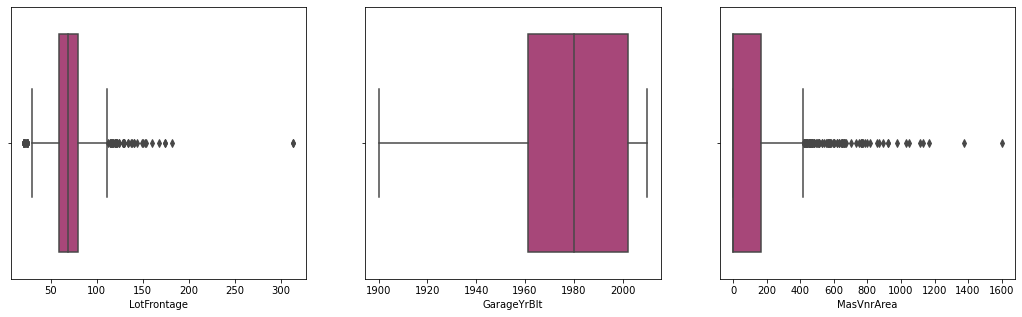

In [1041]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(x = 'LotFrontage', data = house_df, ax=ax1 , palette='magma')
sns.boxplot(x = 'GarageYrBlt', data = house_df, ax=ax2 , palette='magma')
sns.boxplot(x = 'MasVnrArea', data = house_df, ax=ax3 , palette='magma')
plt.show()

LotFrontage and MasVnrArea has lot of outliers hence we will be imputing the null values with the median and for GarageYrBlt we will be using mean

In [1042]:
house_df['LotFrontage']= house_df.LotFrontage.fillna(house_df.LotFrontage.median()) 
house_df['MasVnrArea']= house_df.MasVnrArea.fillna(house_df.MasVnrArea.median())    
house_df['GarageYrBlt']= house_df.GarageYrBlt.fillna(house_df.GarageYrBlt.mean())  

Checking the null nalues of all the categorical columns and take a decision to impute values.

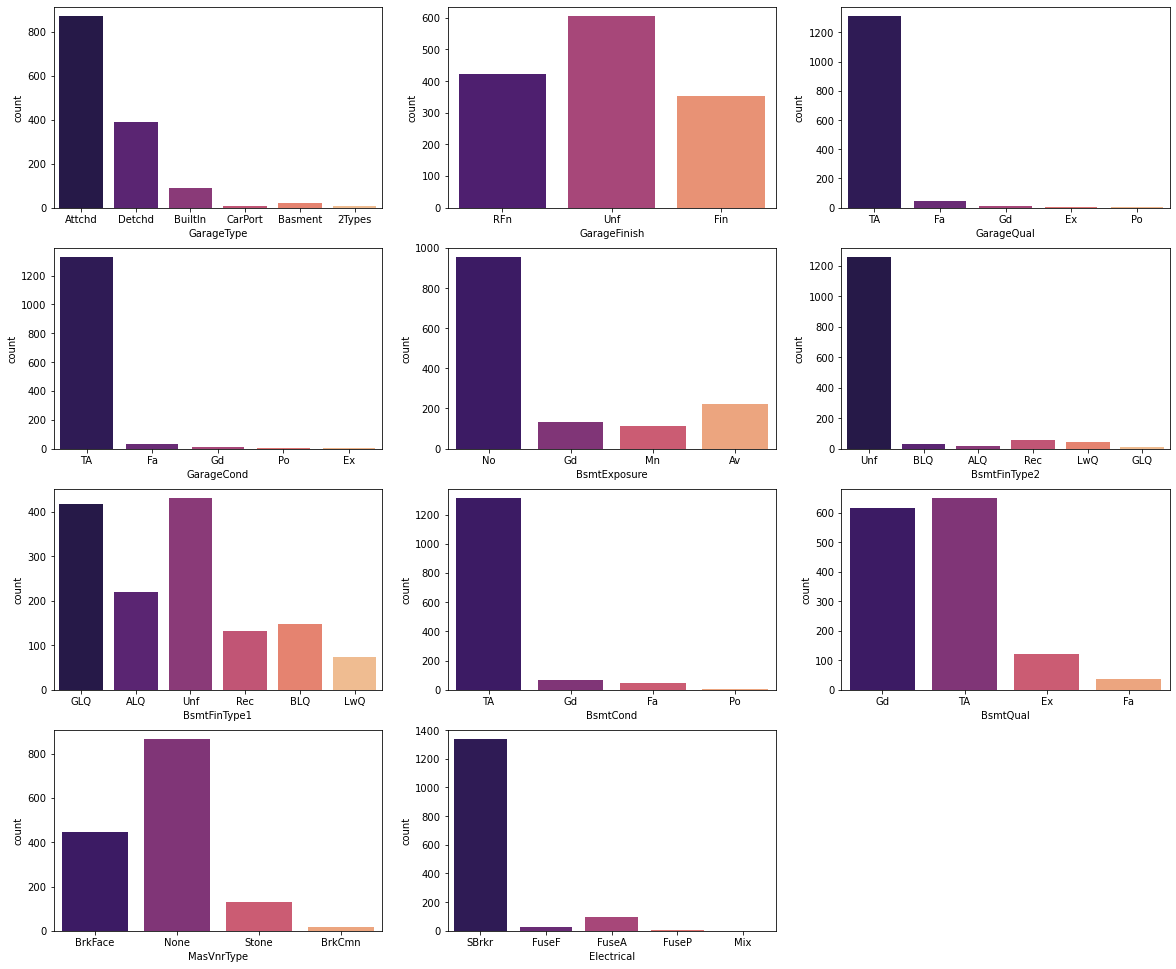

In [1043]:
#Visualising the variables wih missing values

plt.figure(figsize=(20, 17))
plt.subplot(4,3,1)
sns.countplot(x = 'GarageType', data = house_df , palette='magma')
plt.subplot(4,3,2)
sns.countplot(x = 'GarageFinish',  data = house_df , palette='magma')
plt.subplot(4,3,3)
sns.countplot(x = 'GarageQual', data = house_df , palette='magma')
plt.subplot(4,3,4)
sns.countplot(x = 'GarageCond', data = house_df , palette='magma')
plt.subplot(4,3,5)
sns.countplot(x = 'BsmtExposure',  data = house_df , palette='magma')
plt.subplot(4,3,6)
sns.countplot(x = 'BsmtFinType2', data = house_df , palette='magma')
plt.subplot(4,3,7)
sns.countplot(x = 'BsmtFinType1',  data = house_df , palette='magma')
plt.subplot(4,3,8)
sns.countplot(x = 'BsmtCond', data = house_df ,palette='magma')
plt.subplot(4,3,9)
sns.countplot(x = 'BsmtQual', data = house_df , palette='magma')
plt.subplot(4,3,10)
sns.countplot(x = 'MasVnrType',  data = house_df , palette='magma')
plt.subplot(4,3,11)
sns.countplot(x = 'Electrical', data = house_df , palette='magma')
plt.show()

Goint through the meta data provided in the project we can understand the what NA means: <br>
Below are the details <br>
GarageType: NA - No Garage <br>
GarageFinish: NA - No Garage <br>
GarageQual: NA - No Garage <br>
GarageCond: NA - No Garage <br>
BsmtExposure: NA - No Basement <br>
BsmtFinType2: NA - No Basement <br>
BsmtFinType1: NA - No Basement <br>
BsmtCond:  NA - No Basement <br>
BsmtQual:  NA - No Basement <br>

<br>
So we will replace NA with their respective values in these columns

In [1044]:
house_df['GarageType'] = house_df['GarageType'].replace(np.nan, 'No Garage')
house_df['GarageFinish'] = house_df['GarageFinish'].replace(np.nan, 'No Garage')
house_df['GarageCond'] = house_df['GarageCond'].replace(np.nan, 'No Garage')
house_df['GarageQual'] = house_df['GarageQual'].replace(np.nan, 'No Garage')


house_df['BsmtExposure'] = house_df['BsmtExposure'].replace(np.nan, 'No Basement')
house_df['BsmtFinType2'] = house_df['BsmtFinType2'].replace(np.nan, 'No Basement')
house_df['BsmtFinType1'] = house_df['BsmtFinType1'].replace(np.nan, 'No Basement')
house_df['BsmtCond'] = house_df['BsmtCond'].replace(np.nan, 'No Basement')
house_df['BsmtQual'] = house_df['BsmtQual'].replace(np.nan, 'No Basement')

In [1045]:
#Here there are no interpretation for blank value hence we will replace them with the MODE value as it is categorical data
house_df['MasVnrType'] = house_df['MasVnrType'].replace(np.nan, 'None') 
house_df['Electrical'] = house_df['Electrical'].replace(np.nan, 'SBrkr') 

In [1046]:
miss_percentage = round(100*(house_df.isnull().sum()/len(house_df.Id)), 2)
miss_percentage.loc[miss_percentage > 0].sort_values(ascending=False)

Series([], dtype: float64)

#### All the null values are now addressed

In [1047]:
#checking shape of dataframe again
house_df.shape

(1460, 76)

In [1048]:
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [1049]:
#changing numerical values to categorial data of the columns that are categorial and not numeric
#this data is provided in the data decriptio file
house_df['MSSubClass']=house_df['MSSubClass'].replace({
        20:'1-STORY 1946 & NEWER ALL STYLES',
        30:'1-STORY 1945 & OLDER',
        40:'1-STORY W/FINISHED ATTIC ALL AGES',
        45:'1-1/2 STORY - UNFINISHED ALL AGES',
        50:'1-1/2 STORY FINISHED ALL AGES',
        60:'2-STORY 1946 & NEWER',
        70:'2-STORY 1945 & OLDER',
        75:'2-1/2 STORY ALL AGES',
        80:'SPLIT OR MULTI-LEVEL',
        85:'SPLIT FOYER',
        90:'DUPLEX - ALL STYLES AND AGES',
       120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       150:'1-1/2 STORY PUD - ALL AGES',
       160:'2-STORY PUD - 1946 & NEWER',
       180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
       190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'})

house_df['OverallQual']=house_df['OverallQual'].replace({ 
      10:'Very Excellent',
       9:'Excellent',
       8:'Very Good',
       7:'Good',
       6:'Above Average',
       5:'Average',
       4:'Below Average',
       3:'Fair',
       2:'Poor',
       1:'Very Poor'})
house_df['OverallCond']=house_df['OverallCond'].replace({ 
      10:'Very Excellent',
       9:'Excellent',
       8:'Very Good',
       7:'Good',
       6:'Above Average',
       5:'Average',
       4:'Below Average',
       3:'Fair',
       2:'Poor',
       1:'Very Poor'})

In [1050]:
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [1051]:
#checking unique value of columns equal to 1
for col in house_df.columns:
    if house_df[col].nunique() == 1:
        print(col)

All the columns now have more than 1 unique values 

In [1052]:
# Creating derived features
# Converting dates (YearBuilt, YearRemodAdd, GarageYrBlt) to days (DiffYearBuilt, DiffYearRemodAdd, DiffGarageYrBlt) from today
house_df['DiffYearBuilt'] = pd.datetime.now().year - house_df['YearBuilt']
house_df['DiffYearRemodAdd'] = pd.datetime.now().year - house_df['YearRemodAdd']
house_df['DiffGarageYrBlt'] = pd.datetime.now().year - house_df['GarageYrBlt']

In [1053]:
#removing the above 3 columns in the data frame
house_df.drop(['YearBuilt' , 'YearRemodAdd' , 'GarageYrBlt'], axis = 1, inplace=True)

In [1054]:
#removing the id column as this just tells number of rows present in the data
house_df.drop(['Id'], axis = 1, inplace=True)

In [1055]:
house_df.dropna(axis='rows', inplace=True)

In [1056]:
house_df.shape

(1460, 75)

All the rows have values which now we can take for further analysis

Few of the numeric columns are actually categorical upon looking in data like the Year and Month Sold 

In [1057]:
# Converting the Year to String since they are categorical features and should not be treated as numerical features
house_df['YrSold'] = house_df['YrSold'].astype(str)
house_df['MoSold'] = house_df['MoSold'].astype(str)
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DiffYearBuilt,DiffYearRemodAdd,DiffGarageYrBlt
0,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,2,2008,WD,Normal,208500,18,18,18.0
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,5,2007,WD,Normal,181500,45,45,45.0
2,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,9,2008,WD,Normal,223500,20,19,20.0
3,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,2,2006,WD,Abnorml,140000,106,51,23.0
4,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,12,2008,WD,Normal,250000,21,21,21.0


Next step is to check the type of columns like getting a 2 seperate lists for categorical and numeric 

In [1058]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        1460 non-null   object 
 1   MSZoning          1460 non-null   object 
 2   LotFrontage       1460 non-null   float64
 3   LotArea           1460 non-null   int64  
 4   Street            1460 non-null   object 
 5   LotShape          1460 non-null   object 
 6   LandContour       1460 non-null   object 
 7   Utilities         1460 non-null   object 
 8   LotConfig         1460 non-null   object 
 9   LandSlope         1460 non-null   object 
 10  Neighborhood      1460 non-null   object 
 11  Condition1        1460 non-null   object 
 12  Condition2        1460 non-null   object 
 13  BldgType          1460 non-null   object 
 14  HouseStyle        1460 non-null   object 
 15  OverallQual       1460 non-null   object 
 16  OverallCond       1460 non-null   object 


Since there are object, int and float dtypes we will store object in categorical and int and float in numeric

In [1059]:
# Divinding the type of data into numeric and categorical and storing them into two list.
categorical_data = house_df.select_dtypes('object').columns.to_list()
print(len(categorical_data))
print("Categorical Column: " , categorical_data ,"\n")

integer_data = house_df.select_dtypes('int64').columns.to_list()
#print("Ïnteger Column: " , integer_data ,"\n")

continous_float_data = house_df.select_dtypes('float64').columns.to_list()
#print("Float Columns: " , continous_float_data ,"\n")

integer_data_all = integer_data + continous_float_data
print(len(integer_data_all))
print("All Numeric Column: " , integer_data_all, "\n")

#getting the target column name in a variable for future references
target_col = 'SalePrice'

43
Categorical Column:  ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'] 

32
All Numeric Column:  ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 

In [1060]:
# Listing distinct variables for each Categorical columns to address issues if any in the values. 
for col in categorical_data:
    print(col,' : ',house_df[col].unique())

MSSubClass  :  ['2-STORY 1946 & NEWER' '1-STORY 1946 & NEWER ALL STYLES'
 '2-STORY 1945 & OLDER' '1-1/2 STORY FINISHED ALL AGES'
 '2 FAMILY CONVERSION - ALL STYLES AND AGES'
 '1-1/2 STORY - UNFINISHED ALL AGES' 'DUPLEX - ALL STYLES AND AGES'
 '1-STORY PUD (Planned Unit Development) - 1946 & NEWER'
 '1-STORY 1945 & OLDER' 'SPLIT FOYER' 'SPLIT OR MULTI-LEVEL'
 '2-STORY PUD - 1946 & NEWER' '2-1/2 STORY ALL AGES'
 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'
 '1-STORY W/FINISHED ATTIC ALL AGES']
MSZoning  :  ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street  :  ['Pave' 'Grvl']
LotShape  :  ['Reg' 'IR1' 'IR2' 'IR3']
LandContour  :  ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities  :  ['AllPub' 'NoSeWa']
LotConfig  :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope  :  ['Gtl' 'Mod' 'Sev']
Neighborhood  :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blm

Nearly all looks fine to me hence we will not be changing any values here in Categorical Columns

#### Exploratory Data Analysis

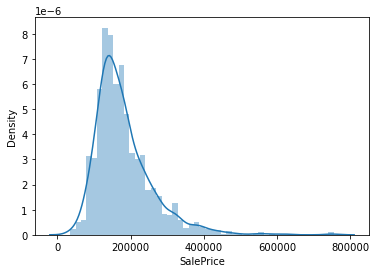

In [1061]:
#target Variable here is the SalePrice Column . let us analyse how it is. 
sns.distplot(house_df['SalePrice'])
plt.show()

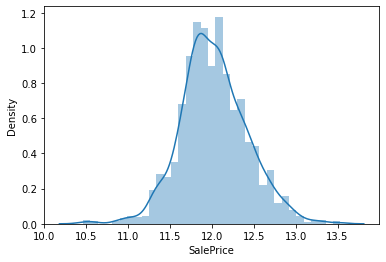

In [1062]:
#Since this Sale Price is left skewed we can try log and recheck its distribution
house_df['SalePrice']=np.log(house_df.SalePrice) #tranforming to form normal disribution
sns.distplot(house_df['SalePrice'])
plt.show()

Let's check all the Numerical columns and their effect on price (Univariate Analysis)

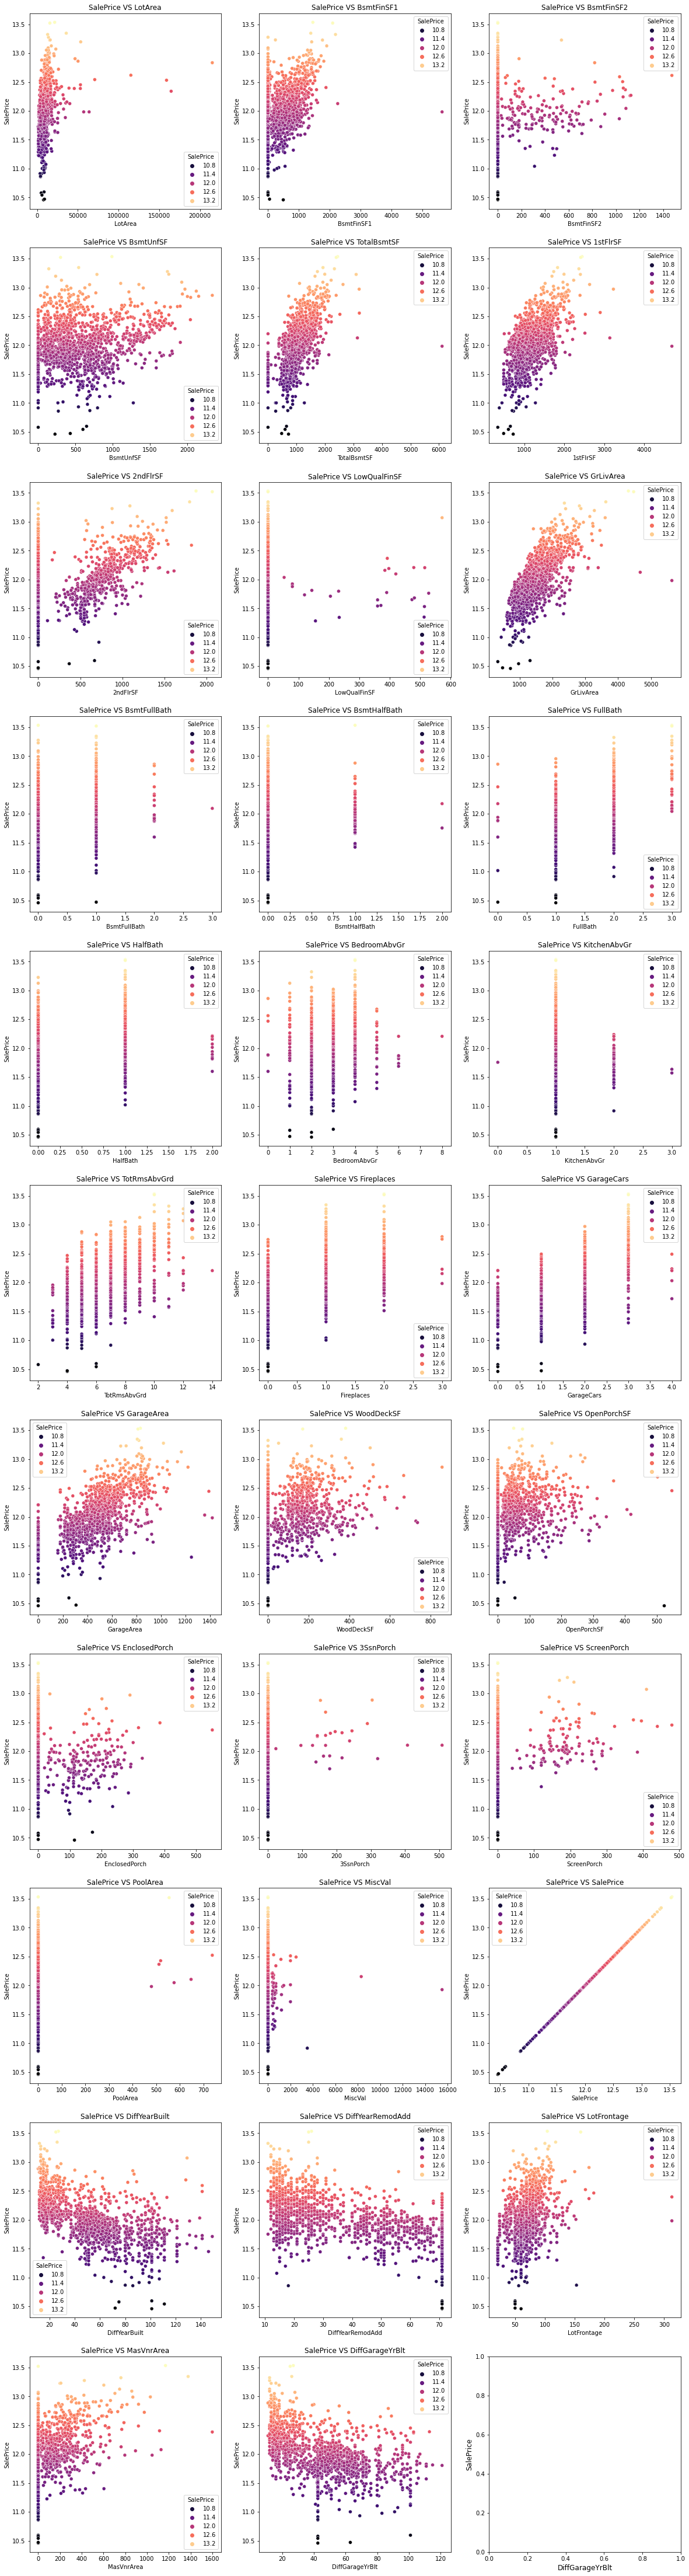

In [1063]:
fig,axs= plt.subplots(11,3,figsize=(20,80))
for i,ax in zip(house_df[integer_data_all],axs.flatten()):
    sns.scatterplot(x=i, y='SalePrice', hue='SalePrice',data=house_df,ax=ax,palette='magma')
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_title('SalePrice'+' VS '+str(i))

#### Observation: 

    1. TotalBsmtSF , 1stFlrSF and GrLivArea tend to have linear relationship with Sale Price
    2. GRLiving Area has a direct corelation with the proce of the property.
    3. New properties are costlier compare to old properties(DIffYearBuilt) , same is applicable for Garage Year Build
    4. Month sold and Year sold has no effect on the price.



Let's check all the Categorical columns and their effect on price (Univariate Analysis)

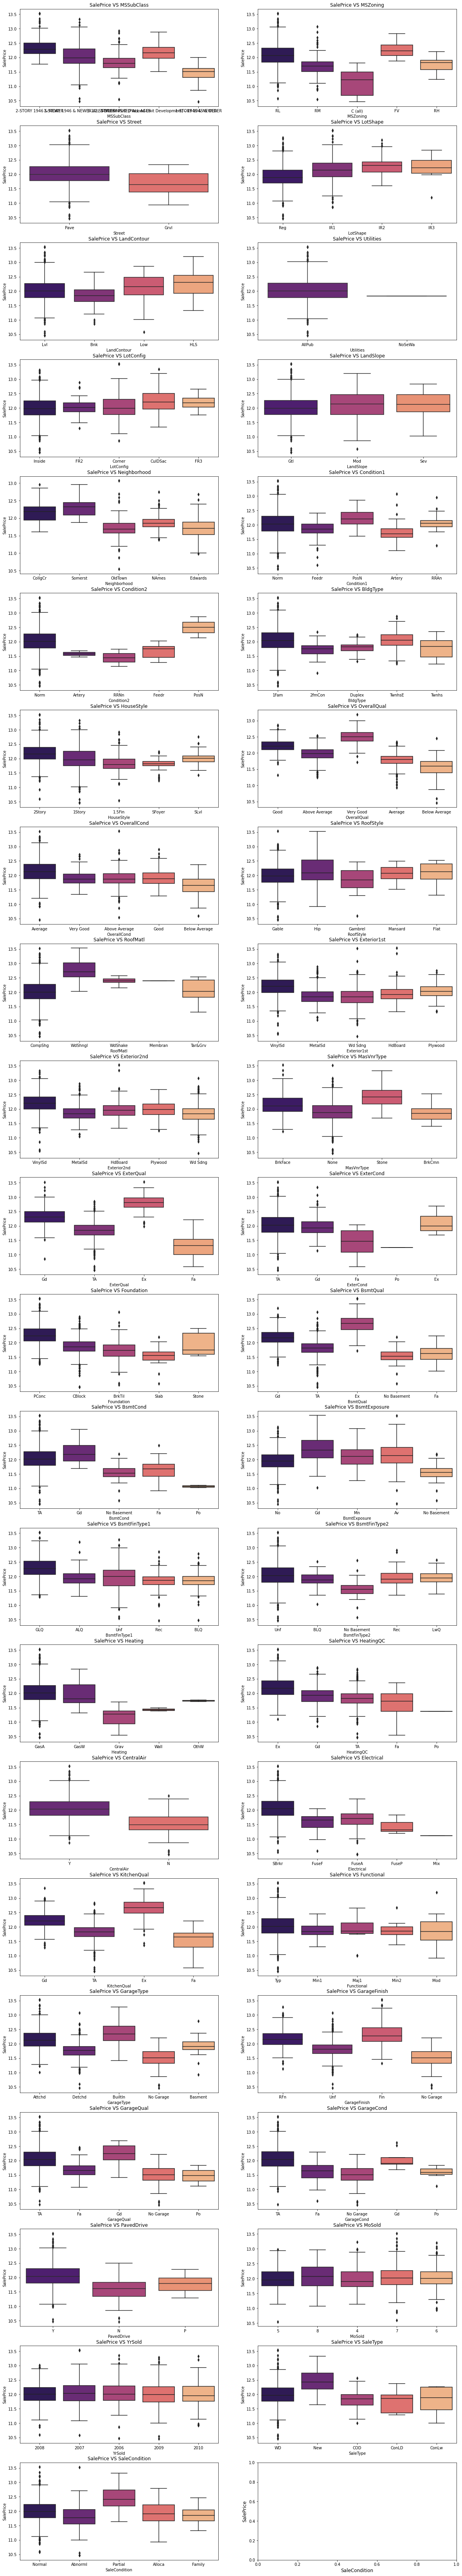

In [1064]:
fig,axs= plt.subplots(22,2,figsize=(20,120))
for i,ax in zip(house_df[categorical_data],axs.flatten()):
    if len(house_df[i].unique()) < 6:
        sns.boxplot(x=i, y='SalePrice',data=house_df,ax=ax,palette='magma')
        plt.xlabel(i,fontsize=12)
        plt.ylabel('SalePrice',fontsize=12)
        ax.set_title('SalePrice'+' VS '+str(i))
    else:
        top_5 = house_df[i].value_counts().index.to_list()[0:5]
        top_5_df = house_df[house_df[i].isin(top_5[0:5])]
        sns.boxplot(x=i, y='SalePrice',data=top_5_df,ax=ax,palette='magma')
        plt.xlabel(i,fontsize=12)
        plt.ylabel('SalePrice',fontsize=12)
        ax.set_title('SalePrice'+' VS '+str(i))
        


#### Observation : 

    High Sale price depends upon :
        Street - Pave
        LotShape - IR2
        LandContour - HLS
        Utilities - AllPub
        Neighborhood - Somerset
        Condition - PosN
        Bldg Type - 1Farm , TwnhsE
        HouseStyle - 2Story
        OverallQual - Very Good
        OverallCond - Average
        RoofMatl - WdShngl
        Exterior - VinlySd
        MasVnrType - Stone
        ExterQual - Ex
        Foundation - PConc
        BsmtQual - Ex
        BsmtCond , BsmtExposure - Gd
        BsmtFinType1 - GLQ
        Heating - GasA
        HeatingQC - Ex
        CentralAir - Y
        Electrical - SBrkr
        KitchenQual - Ex
        GarageType - Builtin
        GarageFinish - Fin
        GarageQual - Gd
        GarageCond - TA
        PavedDrive - Y
        SaleType - New
        SaleCondition - Partial


In [1065]:
house_df.shape

(1460, 75)

In [1066]:
#The Column Utilities can be dropped as it has only one value 1449 times and the other one just one time 
#hence his will not impact the result-
house_df.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [1067]:
house_df.drop(['Utilities'], axis = 1, inplace=True)

In [1068]:
house_df.shape

(1460, 74)

In [1069]:
#updating categorical_data list - removing Utilities entry from there
categorical_data.remove('Utilities')

#### Plotting heat map to understand the correlations

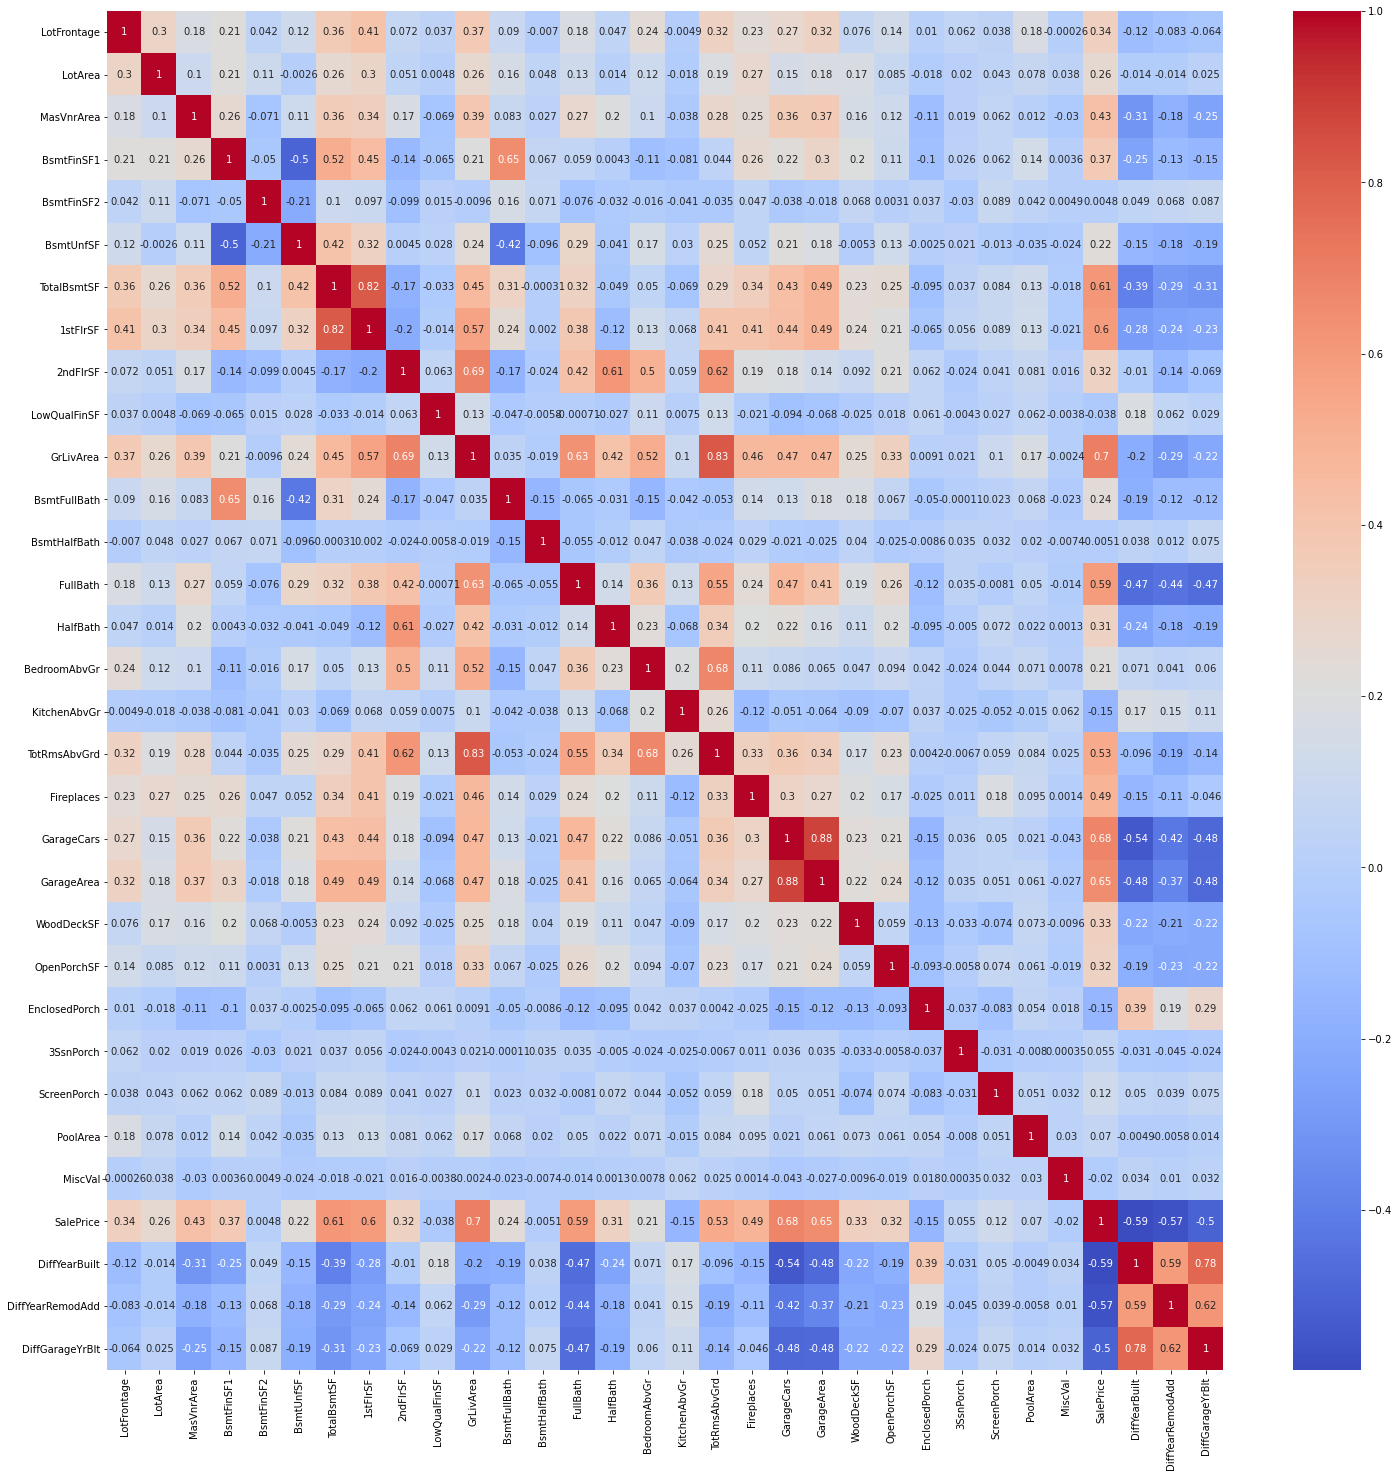

In [1070]:
plt.figure(figsize = (25, 25))
sns.heatmap(house_df.corr(), annot = True, cmap="coolwarm")
plt.show()

In the above heat map we can see that there are highly correlated features which we will need to remove . Shades of Red are highly correlated

    GarageCars and GarageArea are highly correlated(88%) and 
    TotalRmsAbvGrd and GrLivArea are highly correlated (83%)
    TotalBsmtFF and 1stFlrSF are also highly Correlated (82%)

### Adding Dummy variables to categorical data where unique value is more than 2

In [1071]:
for col in categorical_data:
    # Let's drop the first column from dummy df using 'drop_first = True' otherwise it will get multicollinear
    dummies = pd.get_dummies(house_df[col], drop_first = True)
    # Adding prefix to dummy column names so as to identify it later
    dummies = dummies.add_prefix(f'{col}_')
    # Add the results to the original housing dataframe
    house_df = pd.concat([house_df, dummies], axis = 1)
    # Drop original categorical column as we have created the dummies for it
    house_df.drop([col], axis = 1, inplace = True)

house_df.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,0,0,0,0,1,0,0,0,1,0


### Removing outliers from the data

In [1072]:
# Removing outliers > +3 Std. Deviation or < -3 Std. Deviation 
# Checking if outliers exist

z = np.abs(stats.zscore(house_df[integer_data_all]))
# Outlier Removed Records
selected = house_df[integer_data_all][(z < 3).all(axis=1)]
house_df = house_df.loc[selected.index]
house_df

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,0,0,0,0,1,0,0,0,1,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,0,0,0,0,1,0,0,0,1,0
6,75.0,10084,186.0,1369,0,317,1686,1694,0,0,...,0,0,0,0,1,0,0,0,1,0
10,70.0,11200,0.0,906,0,134,1040,1040,0,0,...,0,0,0,0,1,0,0,0,1,0
11,85.0,11924,286.0,998,0,177,1175,1182,1142,0,...,0,0,1,0,0,0,0,0,0,1
12,69.0,12968,0.0,737,0,175,912,912,0,0,...,0,0,0,0,1,0,0,0,1,0
13,91.0,10652,306.0,0,0,1494,1494,1494,0,0,...,0,0,1,0,0,0,0,0,0,1
14,69.0,10920,212.0,733,0,520,1253,1253,0,0,...,0,0,0,0,1,0,0,0,1,0
15,51.0,6120,0.0,0,0,832,832,854,0,0,...,0,0,0,0,1,0,0,0,1,0


## 3. Data Preparation

Let's now prepare the train ans test data and build the model.

In [1073]:
# split into X and y
X = house_df.drop(['SalePrice'], axis=1)

#Target Variable in y 
y = house_df['SalePrice'] # response variable in Y


In [1074]:
X.shape

(1037, 281)

In [1075]:
y.shape

(1037,)

In [1076]:
# Scaling the data using a Minmax Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = DataFrame(X_train)
X_train.columns = X.columns

In [1077]:
X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.610619,0.118259,0.000000,0.191373,0.20751,0.228758,0.389249,0.227247,0.374212,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.014349,0.637500,0.187728,0.00000,0.094771,0.223818,0.025438,0.353189,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.522124,0.244868,0.371875,0.780680,0.00000,0.071351,0.656163,0.681741,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.318584,0.183312,0.000000,0.000000,0.00000,0.488017,0.415199,0.414924,0.519271,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.522124,0.268984,0.295313,0.000000,0.00000,0.593682,0.505097,0.526851,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [1078]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [1079]:
X_train.shape

(725, 281)

In [1080]:
X_test.shape

(312, 281)

In [1081]:
y_train.shape

(725,)

In [1082]:
y_test.shape

(312,)

### 4. Model Building and Evaluation

### Linear Regression

Let's now try predicting Sale Prices, a dataset using linear regression.

In [1083]:
# linear regression with all predictors
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict train
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
# predict test
y_test_pred = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9610275018193662
0.8882232302581191


In [1084]:
# Simple Linear Regression model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
sorted(list(zip(model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

[(10.236, 'constant'),
 (0.877, 'HouseStyle_SLvl'),
 (0.72, 'HouseStyle_1Story'),
 (0.704, 'HouseStyle_SFoyer'),
 (0.642, 'Heating_Grav'),
 (-0.637, 'MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'),
 (-0.524, 'MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER'),
 (-0.491, 'MSSubClass_SPLIT OR MULTI-LEVEL'),
 (-0.407, 'MSSubClass_1-STORY 1945 & OLDER'),
 (0.372, 'MSSubClass_1-1/2 STORY FINISHED ALL AGES'),
 (0.371, 'HouseStyle_1.5Unf'),
 (0.344, 'MSZoning_RH'),
 (-0.332, 'Exterior1st_BrkComm'),
 (-0.32, 'MSSubClass_1-STORY 1946 & NEWER ALL STYLES'),
 (-0.32, 'MSSubClass_SPLIT FOYER'),
 (0.299, 'Heating_Wall'),
 (-0.291, 'Functional_Maj2'),
 (-0.272, 'MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES'),
 (0.263, 'MSZoning_FV'),
 (0.249, 'SaleType_CWD'),
 (0.249, 'SaleCondition_AdjLand'),
 (0.247, 'MSZoning_RM'),
 (0.239, 'MSZoning_RL'),
 (-0.237, 'Neighborhood_MeadowV'),
 (0.233, 'SaleCondition_Partial'),
 (0.218, 'HouseStyle_2Story'),
 (0.212, 'Heating_GasW'),
 (-

Summary:

1. Simple Linear Regression gave us a complex model with most of the coefficients as non-zero values.
2. Simple Linear Regression has not helped us in the feature selection.

### Ridge Regression

In [1085]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [1086]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=100]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013999,0.001096,0.005599,0.001021,0.0001,{'alpha': 0.0001},0.846137,0.846012,0.904000,0.848351,...,0.864519,0.023173,27,0.965854,0.967936,0.962731,0.968956,0.964193,0.965934,0.002299
1,0.014800,0.000749,0.005001,0.000631,0.001,{'alpha': 0.001},0.849908,0.846327,0.904240,0.848778,...,0.865528,0.022616,26,0.965851,0.967936,0.962728,0.968953,0.964193,0.965932,0.002300
2,0.014401,0.001736,0.005395,0.000488,0.01,{'alpha': 0.01},0.862294,0.849168,0.907179,0.850435,...,0.869987,0.021801,24,0.965769,0.967926,0.962625,0.968853,0.964156,0.965866,0.002307
3,0.013997,0.001417,0.006201,0.001163,0.05,{'alpha': 0.05},0.870155,0.857500,0.913401,0.855128,...,0.876980,0.021761,23,0.965523,0.967787,0.962057,0.968457,0.963880,0.965541,0.002385
4,0.019905,0.009031,0.006000,0.003580,0.1,{'alpha': 0.1},0.875100,0.863479,0.916239,0.860189,...,0.882134,0.021096,22,0.965261,0.967551,0.961562,0.968059,0.963545,0.965195,0.002436


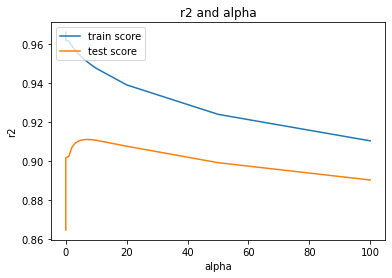

In [1087]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [1088]:
#optimum alpha

alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 3.22895840e-04,  3.89607366e-06, -1.32879694e-05,  7.11332546e-05,
        5.71395234e-05,  5.57440305e-06,  1.33847175e-04,  1.17354875e-04,
        1.72033970e-04, -1.52194998e-04,  1.37193819e-04,  2.05758170e-02,
        0.00000000e+00,  1.29499822e-02,  3.99844316e-03, -7.70860439e-03,
        0.00000000e+00,  7.93747680e-03,  2.40202846e-02,  2.12060535e-02,
        7.39514544e-05,  1.39563854e-04,  2.60397585e-04,  2.02262076e-04,
       -1.71812472e-03,  3.86725003e-04,  0.00000000e+00,  1.44502567e-05,
       -2.66909025e-03, -8.10783292e-04,  2.82164304e-04,  8.57962583e-03,
       -2.82843451e-02,  1.44352294e-02,  6.86574120e-03,  0.00000000e+00,
        4.85209426e-03, -3.03142943e-03,  5.47744520e-02, -9.18423115e-03,
       -5.18887514e-02, -3.59455276e-03, -5.98357065e-03,  8.48402825e-03,
       -9.84997561e-03,  3.08285324e-02,  2.72228988e-02,  1.74093471e-02,
       -3.09029944e-03,  3.58516571e-02,  2.02769371e-02, -1.70895559e-02,
       -3.99544634e-03,  

In [1089]:
ridge.score(X_train,y_train)

0.9458855332210299

In [1090]:
ridge.score(X_test,y_test)

0.9347073839682676

In [1091]:
# Ridge model parameters
model_parameters = list(sorted(ridge.coef_))
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 11.088),
 ('LotFrontage', -0.063),
 ('LotArea', -0.063),
 ('MasVnrArea', -0.057),
 ('BsmtFinSF1', -0.057),
 ('BsmtFinSF2', -0.054),
 ('BsmtUnfSF', -0.052),
 ('TotalBsmtSF', -0.052),
 ('1stFlrSF', -0.048),
 ('2ndFlrSF', -0.047),
 ('LowQualFinSF', -0.046),
 ('GrLivArea', -0.038),
 ('BsmtFullBath', -0.038),
 ('BsmtHalfBath', -0.036),
 ('FullBath', -0.036),
 ('HalfBath', -0.035),
 ('BedroomAbvGr', -0.034),
 ('KitchenAbvGr', -0.03),
 ('TotRmsAbvGrd', -0.03),
 ('Fireplaces', -0.028),
 ('GarageCars', -0.028),
 ('GarageArea', -0.027),
 ('WoodDeckSF', -0.025),
 ('OpenPorchSF', -0.025),
 ('EnclosedPorch', -0.025),
 ('3SsnPorch', -0.025),
 ('ScreenPorch', -0.024),
 ('PoolArea', -0.022),
 ('MiscVal', -0.022),
 ('DiffYearBuilt', -0.022),
 ('DiffYearRemodAdd', -0.021),
 ('DiffGarageYrBlt', -0.019),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -0.019),
 ('MSSubClass_1-STORY 1945 & OLDER', -0.018),
 ('MSSubClass_1-STORY 1946 & NEWER ALL STYLES', -0.018),
 ('MSSubClass_1-STORY PUD (Plann

### Lasso

In [1092]:
params = {'alpha': [0.00006,0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008 ]}
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [6e-05, 0.0006, 0.0008, 0.001, 0.002, 0.004,
                                   0.006, 0.008]},
             return_train_score=True, scoring='r2', verbose=1)

In [1093]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.120889,0.030818,0.006256,0.007662,0.00006,{'alpha': 6e-05},0.889352,0.878604,0.918351,0.872253,...,0.894385,0.018433,4,0.963712,0.965728,0.959567,0.966273,0.961747,0.963406,0.002498
1,0.018756,0.006247,0.003124,0.006248,0.0006,{'alpha': 0.0006},0.904711,0.906686,0.925551,0.896918,...,0.909615,0.009684,1,0.946587,0.948277,0.943327,0.947719,0.941920,0.945566,0.002503
2,0.018755,0.006245,0.006250,0.007655,0.0008,{'alpha': 0.0008},0.903672,0.907517,0.923923,0.897545,...,0.908335,0.008744,2,0.942535,0.943146,0.938756,0.943893,0.937135,0.941093,0.002656
3,0.016396,0.001547,0.003126,0.006251,0.001,{'alpha': 0.001},0.901385,0.906698,0.922789,0.897259,...,0.906249,0.008810,3,0.938745,0.938994,0.935020,0.940110,0.933084,0.937191,0.002675
4,0.012500,0.006250,0.006251,0.007656,0.002,{'alpha': 0.002},0.887999,0.896949,0.911333,0.890582,...,0.893329,0.010552,5,0.919331,0.919214,0.914465,0.920019,0.914394,0.917485,0.002510


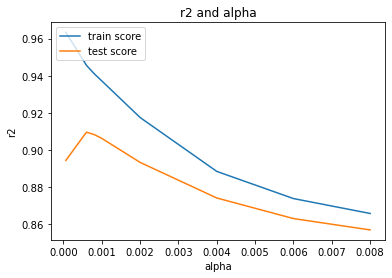

In [1094]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')

plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [1095]:
#optimum alpha

alpha =0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

Lasso(alpha=0.001)

In [1096]:
lasso.coef_

array([ 4.49808535e-04,  3.14809581e-06, -2.67080853e-06,  1.43580727e-04,
        9.30040070e-05,  6.84767806e-05,  5.40779075e-05,  2.26270205e-04,
        2.40966845e-04,  1.10700058e-04,  6.17478249e-05,  1.99261462e-02,
        0.00000000e+00,  5.96173522e-03, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  5.25847597e-03,  2.48309264e-02,  1.99406794e-02,
        1.34341594e-04,  1.42434458e-04,  2.60921856e-04,  2.00581376e-04,
       -0.00000000e+00,  4.64474802e-04,  0.00000000e+00,  2.40984255e-05,
       -2.94689087e-03, -1.12227156e-03,  5.86359401e-04,  0.00000000e+00,
       -3.57403977e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  5.05120976e-02, -0.00000000e+00,
       -5.49534511e-02, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.53122119e-04,  0.00000000e+00,  0.00000000e+00,
       -1.47283664e-02,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -9.19700713e-04,  

In [1097]:
lasso.score(X_train,y_train)

0.9338091085594149

In [1098]:
lasso.score(X_test,y_test)

0.930921842239534

In [1099]:
# lasso model parameters
model_parameters_L = list(sorted(lasso.coef_))
model_parameters_L.insert(0, lasso.intercept_)
model_parameters_L = [round(x, 3) for x in model_parameters_L]
cols = X.columns
cols = cols.insert(0, "constant")
list((zip(cols, model_parameters_L)))

[('constant', 11.065),
 ('LotFrontage', -0.07),
 ('LotArea', -0.066),
 ('MasVnrArea', -0.065),
 ('BsmtFinSF1', -0.059),
 ('BsmtFinSF2', -0.055),
 ('BsmtUnfSF', -0.043),
 ('TotalBsmtSF', -0.04),
 ('1stFlrSF', -0.039),
 ('2ndFlrSF', -0.039),
 ('LowQualFinSF', -0.037),
 ('GrLivArea', -0.036),
 ('BsmtFullBath', -0.024),
 ('BsmtHalfBath', -0.023),
 ('FullBath', -0.017),
 ('HalfBath', -0.015),
 ('BedroomAbvGr', -0.015),
 ('KitchenAbvGr', -0.014),
 ('TotRmsAbvGrd', -0.011),
 ('Fireplaces', -0.011),
 ('GarageCars', -0.008),
 ('GarageArea', -0.007),
 ('WoodDeckSF', -0.006),
 ('OpenPorchSF', -0.005),
 ('EnclosedPorch', -0.005),
 ('3SsnPorch', -0.005),
 ('ScreenPorch', -0.003),
 ('PoolArea', -0.003),
 ('MiscVal', -0.003),
 ('DiffYearBuilt', -0.002),
 ('DiffYearRemodAdd', -0.001),
 ('DiffGarageYrBlt', -0.001),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -0.0),
 ('MSSubClass_1-STORY 1945 & OLDER', -0.0),
 ('MSSubClass_1-STORY 1946 & NEWER ALL STYLES', 0.0),
 ('MSSubClass_1-STORY PUD (Planned Unit

### Observations from Rigde and Lasso Regression

The R score for Ridge and Lasso are -

    Ridge : Train :94.5 Test :93.4
    Lasso : Train :93.3 Test :93.0

Top 5 most significant variables in Ridge are:

     SaleCondition_Partia	0.087
     SaleCondition_Normal	0.075
     SaleCondition_Family	0.070
     SaleCondition_Alloca	0.062
     SaleCondition_AdjLand	0.060

    
Top 5 most significant variables in Lasso are:

     SaleCondition_Partial	0.124
     SaleCondition_Normal	0.122
     SaleCondition_Family	0.075
     SaleCondition_Alloca	0.067
     SaleCondition_AdjLand	0.061

    
These Varaiables are directly proportional to each other.

    Optimal Value of alpha for ridge : 10
    Optimal Value of alpha for Lasso : 0.001
    
Because of Feature selection as well we can choose Lasso regression in this case.

---

#### Subjective Questions

Q1 . What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

Ans: 
The R score for Ridge and Lasso are -

    Ridge : Train :94.5 Test :93.4
    Lasso : Train :93.3 Test :93.0

If we double the value of alpha for both Ridge and Lasso then in case of ridge it will lower the coefficients and in case of lasso it will make less important feature turn zero


---


Q2: You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?

Ans: 
Optimal Value of alpha for ridge and lasso regression are: 

    • Optimal Value of lambda for ridge: 10 
    • Optimal Value of lambda for Lasso: 0.001 
    
As we Got good score for both the models so we can go with Lasso regression as it results in model parameters such that lesser important features coefficients become zero. 

    Ridge : Train :94.5 Test :93.4
    Lasso : Train :93.3 Test :93.0

---

Q3: After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?



In [1101]:
#Removing the 5 most important predictor variables from the incoming dataset
X_test_rfe3 = X_test.drop(['SaleCondition_Partial','SaleCondition_Normal','SaleCondition_Family','SaleCondition_Alloca','SaleCondition_AdjLand'],axis=1)
X_train_rfe3 = X_train.drop(['SaleCondition_Partial','SaleCondition_Normal','SaleCondition_Family','SaleCondition_Alloca','SaleCondition_AdjLand'],axis=1)

# Building Lasso Model with the new dataset
lasso3 = Lasso(alpha=0.0001,random_state=100)
lasso3.fit(X_train_rfe3,y_train)
lasso3_coef = lasso3.coef_
y_test_pred = lasso3.predict(X_test_rfe3)
print('The R2 Score of the model on the test dataset is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset is', mean_squared_error(y_test, y_test_pred))
lasso3_coeff = pd.DataFrame(np.atleast_2d(lasso3_coef),columns=X_train_rfe3.columns)
lasso3_coeff = lasso3_coeff.T
lasso3_coeff.rename(columns={0: 'Lasso Co-Efficient'},inplace=True)
lasso3_coeff.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
print('The most important predictor variables are as follows:')
lasso3_coeff.head(5)

The R2 Score of the model on the test dataset is 0.922367864892125
The MSE of the model on the test dataset is 0.010447866503062198
The most important predictor variables are as follows:


,Lasso Co-Efficient
Street_Pave,0.452920
SaleType_CWD,0.191842
Neighborhood_Crawfor,0.143251
OverallCond_Excellent,0.129640
Functional_Typ,0.126741


---
